In [1]:
%load_ext autoreload
%autoreload 2

# Handling Missing Data with Parallel Processing

We might not have mercury concentration levels for every single functional group or we may want to include some level of uncertainty in the observed equlibrium. 

This poses a problem for the analysis done in notebook 2: We cannot build the constraint matrix $\mathbf{K}$ if we don't know the concentrations $\mathbf{C}_{obs}$.

## Nested Sampling

We treat the missing concentrations as uncertain variables to be sampled, creating a nested sampling loop:

1.  Outer Loop (Concentration Sampling): Sample plausible concentrations for the unobserved groups (e.g., based on literature ranges or model estimates).
2.  Inner Loop (Parameter Space): For each concentration sample, treating it as the "truth", sample the valid ecotracer parameters from the Nullspace.

This results in a larger set of samples that captures both the uncertainty in the data (Observation Error/Missing Data) and the uncertainty in the parameters.

In [2]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
import pyewe as ewe
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from ecotracer_analytics.core import EcopathSource, EcotracerSource
from ecotracer_analytics.linear_system import calculate_equilibrium
from ecotracer_analytics.reverse_analysis import (
    ParameterDefinition, 
    LinearConstraintBuilder, 
    ConstrainedSolver
)
from ecotracer_analytics.dynamics import simulate_dynamics

plt.style.use('seaborn-v0_8')
PLOT_DIR = "nested_sampling_results"
os.makedirs(PLOT_DIR, exist_ok=True)

## 1. Setup and Definitions

Suppose, we only had observations for group 10 to 40, then we could explore impact of uncertainty in the equilibrium of the unobserved groups by sampling from a wide range of guesses and exploring the parameter space with constraints imposed by the sampled equlibriums. 

**Configuration:**
*   **Fixed Indices (Observed):** Groups 5 to 40.
*   **Unconstrained Indices (Unobserved):** Groups 1 to 5 and 41 to End (mostly lower trophic levels).
*   **Sampling:** 10 Concentration Scenarios x 100 Parameter Samples each = 1,000 Total Ensembles.

In [3]:
MODEL_PATH = "East Bass Strait.eiixml"
SCENARIO_ECOSIM = "constant fishing"
SCENARIO_ECOTRACER = "smaller_equi"

# Groups to Fix (indices) vs Groups to Sample
FIXED_INDICES = set(range(5, 41))
FIXED_INDICES.add(0)
N_CONC_SAMPLES = 1000     # Outer Loop iterations (Concentration Scenarios)
N_PARAM_SAMPLES = 10000   # Inner Loop iterations (Nullspace Samples per Scenario)
TARGET_CV = 0.25   # +/- 25% spread for unconstrained concentrations
N_JOBS = 20             # Use all available cores

print("Loading model...")
scen_int = ewe.EwEScenarioInterface(
    MODEL_PATH, 
    ecosim_scenario=SCENARIO_ECOSIM, 
    ecotracer_scenario=SCENARIO_ECOTRACER
)
scen_int.run_scenarios(pd.DataFrame({"scenario": [1]}))
core = scen_int._core_instance

path_source = EcopathSource(core)
baseline_source = EcotracerSource(core)

# Baseline Equilibrium (The reference point)
C_baseline = calculate_equilibrium(path_source, baseline_source)
N_GROUPS = len(C_baseline)
UNCONSTRAINED_INDICES = [i for i in range(N_GROUPS) if i not in FIXED_INDICES]

print(f"Total Groups: {N_GROUPS}")
print(f"Fixed Concentrations: {len(FIXED_INDICES)} (Indices 0-40)")
print(f"Sampled Concentrations: {len(UNCONSTRAINED_INDICES)} (Indices 41+)")

Loading model...


Running scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Total Groups: 60
Fixed Concentrations: 37 (Indices 0-40)
Sampled Concentrations: 23 (Indices 41+)


## 2. Prepare Parameter Definitions

We set up the `ParameterDefinition` object.
*   **Fixed:** Base Inflow (0), Immigration Concentrations.
*   **Parameter Guess:** To explore the idea of have an initial parameter guess that does not produce the target equilibrium, we increased parameter values by 5%.
*   **Parameter Bounds:** Wide parameter bouds of 0.1 - 10x of the initial guess.

In [4]:
param_def = ParameterDefinition(path_source, baseline_source)

for param in param_def.params[1:]:
    param.lb = param.prior * 0.1
    param.ub = param.prior * 10

    
    if param.param_type == "assim_eff":
        if param.prior == 1:
            param.lb = 1
            param.ub = 1
            param.prior = 1
            param.is_fixed = True
        else:
            param.ub = min(param.ub, 1.0)
            param.prior = min(param.prior, 1.0)
        
    if param.lb == param.ub:
        param.is_fixed = True

    # Suppose that our initial guess was actually 5% larger for all parameters than a solution that would produce equilibrium
    if not param.is_fixed:
        param.prior = min(1.05 * param.prior, param.ub)

    if (param.prior == param.ub or param.prior == param.lb) and param.prior != 0 and not param.is_fixed:
        print(param)
    if param.prior > param.ub or param.prior < param.lb:
        print(f"Bounds Violations with: {param}")

# We create instances here, but we will create new ones inside parallel workers if needed
builder = LinearConstraintBuilder(path_source, baseline_source, param_def)
solver = ConstrainedSolver()

## 3. Parallel Sampling

1. Sample a possible contaminent equlibrium with a variance of +/- 25% variance
2. Sample from the set of parameters that reproduce the sampeled equilibrium, ignoring if there are no solutions.

In [5]:
def process_scenario(seed, C_base, unconstrained_indices, target_cv, builder, solver, param_def, n_param_samples):
    """
    Worker function to process a single concentration scenario.
    Returns: (Samples, Concentrations)
    """
    
    import warnings
    warnings.simplefilter("ignore", category=UserWarning)
    rng = np.random.default_rng(seed)
    
    # --- A. Sample Unconstrained Concentrations ---
    C_candidate = C_base.copy()
    
    # Pre-calculate sigma squared for LogNormal: ln(1 + CV^2)
    sigma_sq = np.log(1 + target_cv**2)
    sigma = np.sqrt(sigma_sq)
    
    # Truncation limits in standard deviations (e.g., +/- 2 sigma)
    # This prevents extremely small or large outliers
    n_sigma = 2.0 
    
    for idx in unconstrained_indices:
        base_val = C_base[idx]
        if base_val > 0:
            # Calculate mu for LogNormal: ln(mean) - sigma^2/2
            mu = np.log(base_val) - sigma_sq / 2.0
            
            # Sample from Truncated Normal in log-space
            # truncnorm takes bounds (a, b) in standard normal units
            log_val = truncnorm.rvs(
                -n_sigma, n_sigma, 
                loc=mu, scale=sigma, 
                random_state=rng
            )
            
            # Exponentiate to get concentration
            C_candidate[idx] = np.exp(log_val)
            
    # --- B. Build Constraints ---
    try:
        K, r = builder.build(C_candidate)
        
        # --- C. Optimize ---
        theta_opt, _ = solver.solve(K, r, param_def)
        
        # Verify
        residual = np.linalg.norm(K @ theta_opt - r)
        if residual > 1e-4:
            return None # Failed to converge
            
        # --- D. Sample Nullspace ---
        samples = solver.sample(
            K, r, param_def,
            n_samples=n_param_samples,
            sigma=0.25,
            x_center=theta_opt
        )
        
        # Expand concentrations to match samples (N_samples x N_groups)
        C_expanded = np.tile(C_candidate, (n_param_samples, 1))
        
        return samples, C_expanded
        
    except Exception as e:
        return None

# Run Parallel Execution
print(f"Starting Parallel Nested Sampling on {N_JOBS} cores...")

seeds = np.random.randint(0, 100000, size=N_CONC_SAMPLES)


results = Parallel(n_jobs=N_JOBS)(
    delayed(process_scenario)(
        seed, C_baseline, UNCONSTRAINED_INDICES, TARGET_CV, 
        builder, solver, param_def, N_PARAM_SAMPLES
    ) 
    for seed in tqdm(seeds, desc="Scenarios")
)

# Filter out failed runs
valid_results = [res for res in results if res is not None]

if not valid_results:
    print("All scenarios failed!")
    sys.exit()

# Unpack results
mega_ensemble = np.vstack([res[0] for res in valid_results])
mega_ensemble_conc = np.vstack([res[1] for res in valid_results])
valid_results = [res[0] for res in results if res is not None]

print(f"Generated Mega-Ensemble with shape: {mega_ensemble.shape}")
print(f"Generated Mega-Ensemble Concentrations with shape: {mega_ensemble_conc.shape}")

Starting Parallel Nested Sampling on 20 cores...


Scenarios:   0%|          | 0/1000 [00:00<?, ?it/s]

Generated Mega-Ensemble with shape: (2650000, 298)
Generated Mega-Ensemble Concentrations with shape: (2650000, 60)


## 4. Parameter Distributions

We visualize the distributions of key parameters.
* The Blue histogram shows the all sampled parameter values $P(\Theta = \theta)$.

* The Orange histogram shows the sampled parameter values for a single sampled equilibrium concentration $P(\Theta = \theta | C_{eq} = c)$.

This highlights how much the missing concentration data contributes to parameter uncertainty and information about equilibrim constrains parameter estimates.

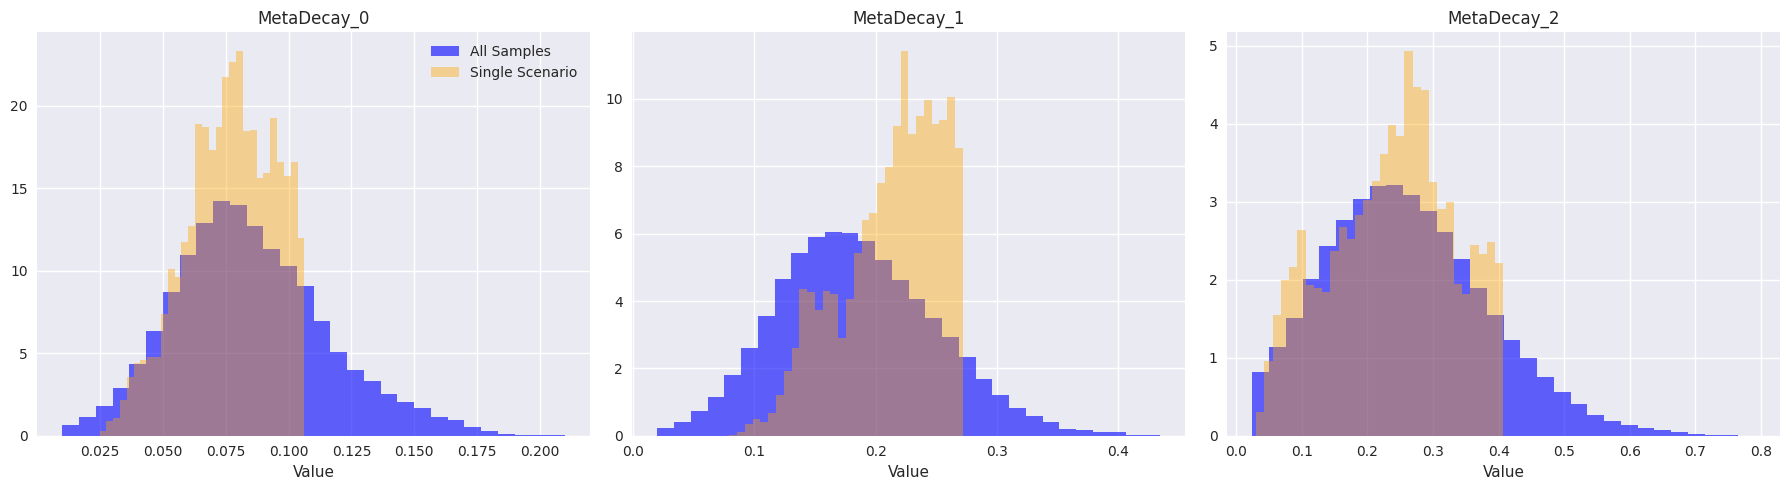

In [6]:
PARAM_PLOT_DIR = os.path.join(PLOT_DIR, "params")
os.makedirs(PARAM_PLOT_DIR, exist_ok=True)

# Select a few interesting parameters to plot inline
plot_indices = [p.index for p in param_def.params if "MetaDecay" in p.name and not p.is_fixed][:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, idx in zip(axes, plot_indices):
    param = param_def.params[idx]
    
    # Total Uncertainty
    total_samples = mega_ensemble[:, idx]
    ax.hist(total_samples, bins=30, alpha=0.6, color='blue', density=True, label='All Samples')

    # Single Scenario Uncertainty (first valid batch)
    single_scenario = valid_results[0][:, idx]
    ax.hist(single_scenario, bins=30, alpha=0.4, color='orange', density=True, label='Single Scenario')
    
    ax.set_title(f"{param.name}")
    ax.set_xlabel("Value")
    if idx == plot_indices[0]:
        ax.legend()

plt.tight_layout()
plt.show()

## 5. Simulation

We now run forward simulations for every parameter set.
We increase the base inflow rate and immigration concentration of mesopelagics by 50% to see high the new equilibruim forms.

In [7]:
def run_simulation(theta, builder, path_source, y0, t_span, t_eval):
    """
    Worker function to run a single simulation.
    """
    # Reconstruct Source from Parameter Vector
    # Note: We rely on the builder's internal helper which we made public-ish
    # or we manually map it. 
    # For robust parallelization, we reconstruct the source object inside the worker.
    # However, 'core' cannot be pickled easily.
    # So we use the 'builder' helper if it doesn't depend on the core connection heavily.
    # The builder._create_tracer_source_with_params creates a Dummy object, which is pickle-safe.
    
    source_sim = builder._create_tracer_source_with_params(theta)
    
    # Apply Perturbation
    source_sim.base_inflow = source_sim.base_inflow * 1.5
    source_sim.immigration_c[45] *= 1.5

    # Simulate
    sol = simulate_dynamics(
        path_source, 
        source_sim, 
        y0, 
        t_span, 
        t_eval=t_eval,
        method="Radau"
    )
    
    # Return concentrations at t_eval (Groups x Time)
    return sol.y

print("Starting Parallel Simulations...")

t_span = (0, 20)
t_eval = np.linspace(0, 20, 20)

# Use joblib to parallelize
# Note: path_source contains large arrays, joblib handles shared memory efficiently for numpy arrays
sim_results = Parallel(n_jobs=N_JOBS)(
    delayed(run_simulation)(
        theta, builder, path_source, y0, t_span, t_eval
    )
    for (y0, theta) in tqdm(zip(mega_ensemble_conc, mega_ensemble), desc="Simulating")
)

# Convert to array: (Samples, Groups, Time)
sim_array = np.array(sim_results)
print(f"Simulation Results Shape: {sim_array.shape}")

Starting Parallel Simulations...


Simulating: 0it [00:00, ?it/s]

Simulation Results Shape: (2650000, 60, 20)


## 6. Visualization: Predictive Ensembles

We plot the time-series traces for the Environment and specific functional groups.

*   **Mean (Black Line):** The average prediction.
*   **95% CI (Dashed Lines):** The confidence interval.
*   **Blue Traces:** Individual simulation runs (sub-sampled for clarity).

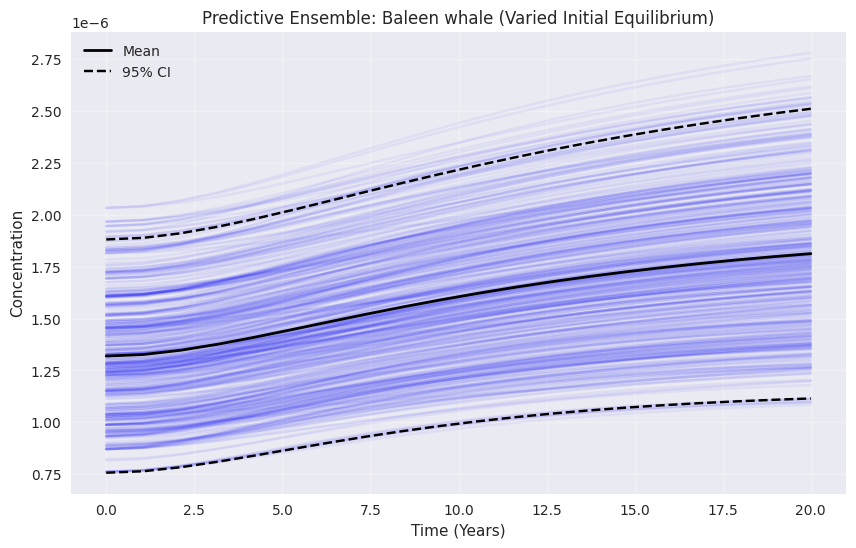

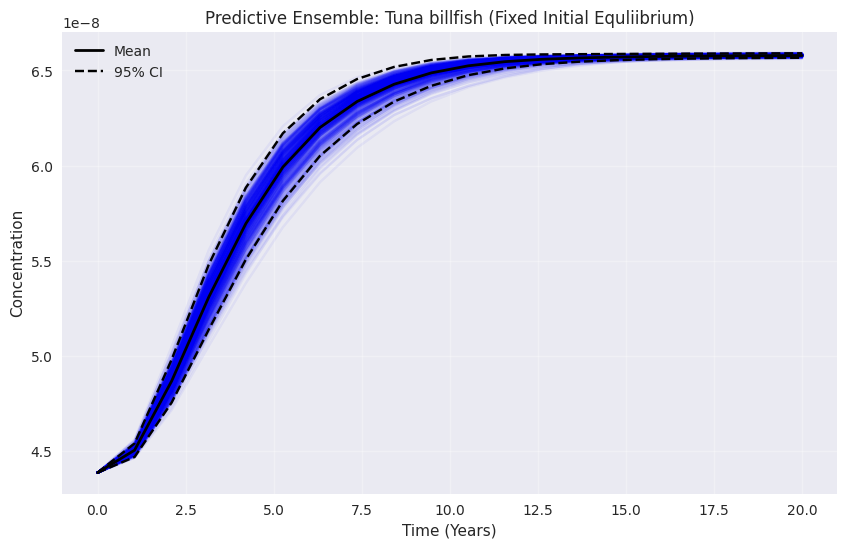

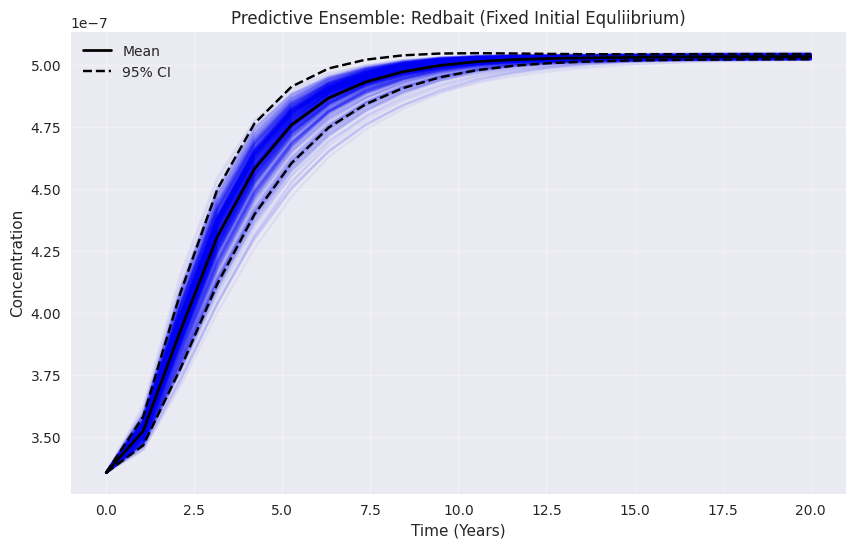

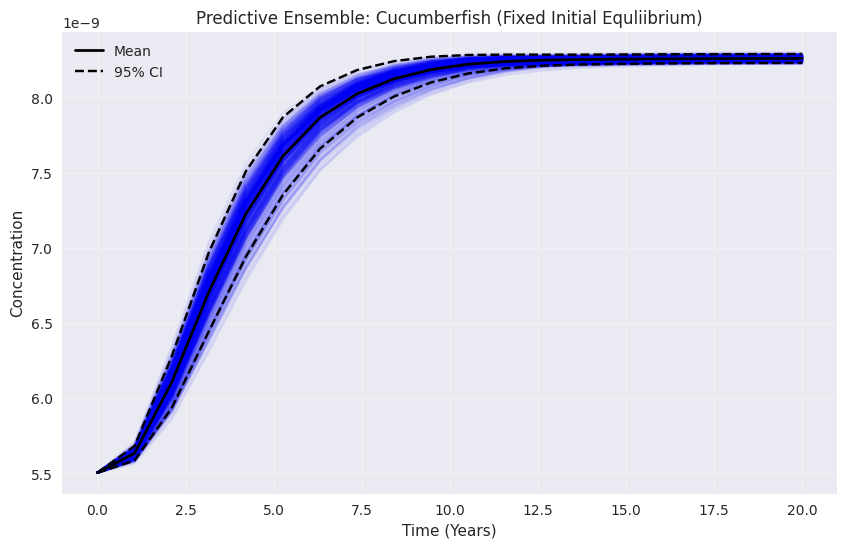

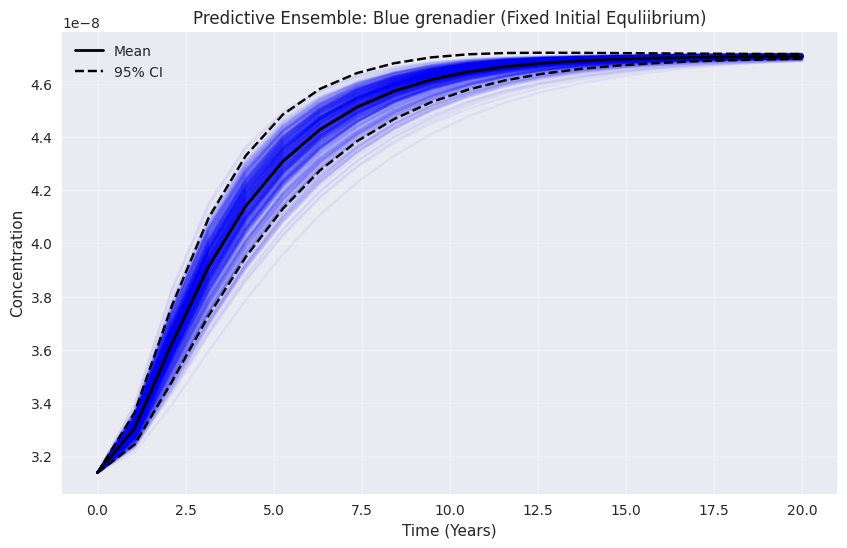

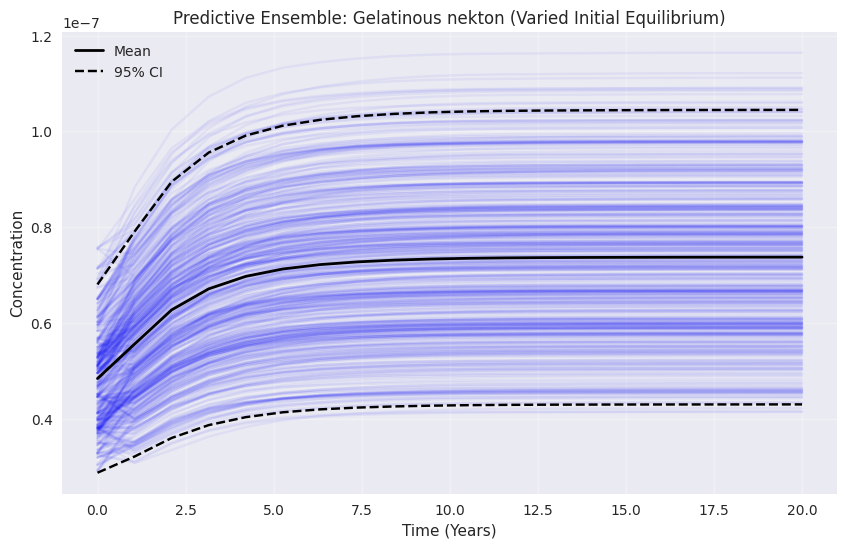

In [8]:
SIM_PLOT_DIR = os.path.join(PLOT_DIR, "simulations")
os.makedirs(SIM_PLOT_DIR, exist_ok=True)

def plot_ensemble_trace(sim_data, mega_ens_conc, group_idx, group_name):
    """
    sim_data: (Samples, Groups, Time)
    """
    # Extract data for this group: (Samples, Time)
    traces = sim_data[:, group_idx, :]
    
    plt.figure(figsize=(10, 6))
    
    # Plot subset of traces
    n_plot = min(500, len(traces))
    indices = np.random.choice(len(traces), n_plot, replace=False)
    plt.plot(t_eval, traces[indices].T, color='blue', alpha=0.05)
    
    # Stats
    mean_trace = np.mean(traces, axis=0)
    std_trace = np.std(traces, axis=0)
    
    plt.plot(t_eval, mean_trace, color='black', linewidth=2, label="Mean")
    plt.plot(t_eval, mean_trace + 1.96*std_trace, 'k--', label="95% CI")
    plt.plot(t_eval, mean_trace - 1.96*std_trace, 'k--')
    
    plt.title(f"Predictive Ensemble: {group_name}")
    plt.xlabel("Time (Years)")
    plt.ylabel("Concentration")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save
    safe_name = group_name.replace(" ", "_")
    plt.savefig(os.path.join(SIM_PLOT_DIR, f"trace_{safe_name}.png"))
    plt.show()

for i in [1, 5, 10, 20, 30, 51]:
    plot_ensemble_trace(sim_array, mega_ensemble_conc, i, core.get_functional_group_names()[i].replace("/", " ") + (" (Fixed Initial Equliibrium)" if i in FIXED_INDICES else " (Varied Initial Equilibrium)"))


## 7. Analytical Equilibrium Perturbation

In addition to dynamic simulations, we can instantly calculate the *asymptotic* equilibrium that the system will eventually reach under the tripled inflow.

Since $C_{eq} = M^{-1} \cdot b$, we can compute this for every parameter set in the Mega-Ensemble without running a time-stepping simulation.


Calculating Analytical Equilibria...


Equilibrium Calc:   0%|          | 0/2650000 [00:00<?, ?it/s]

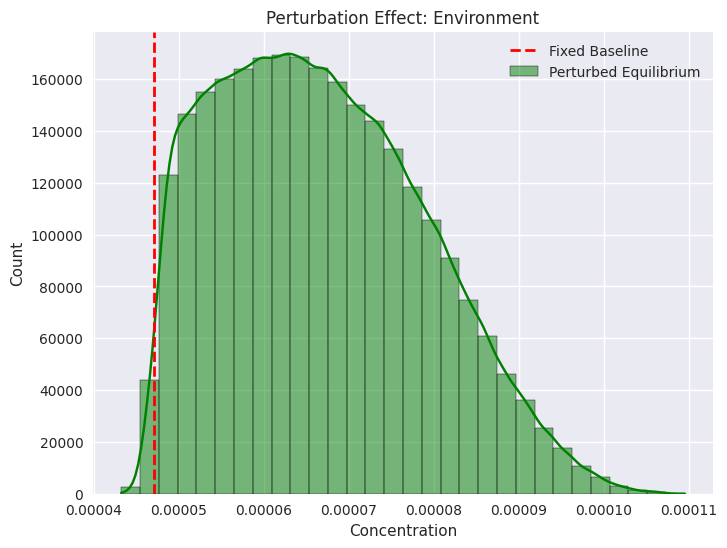

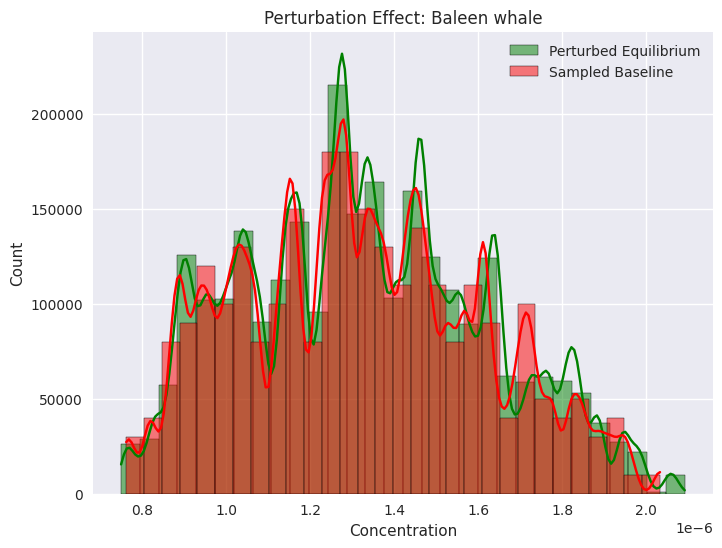

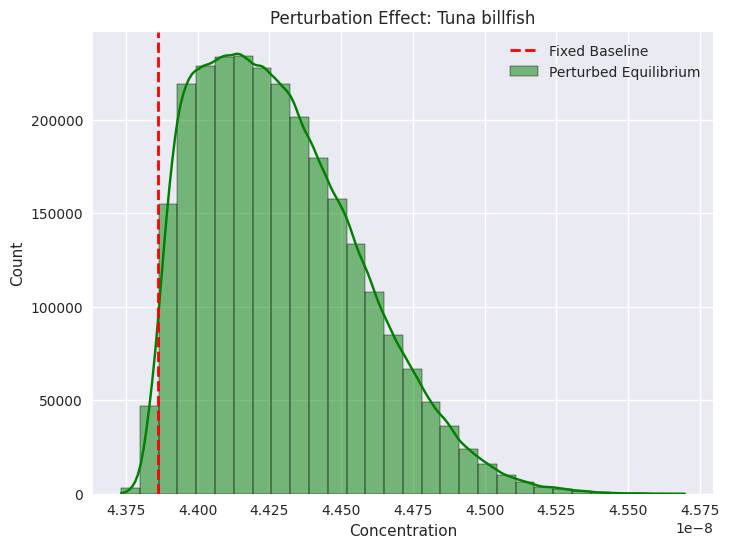

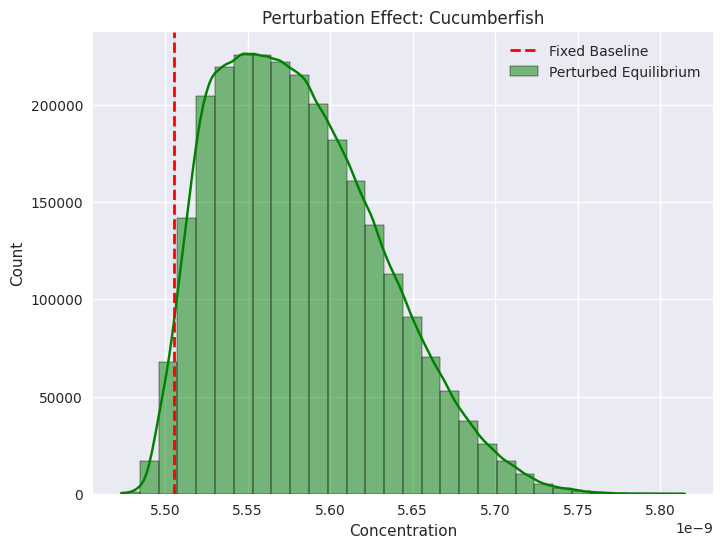

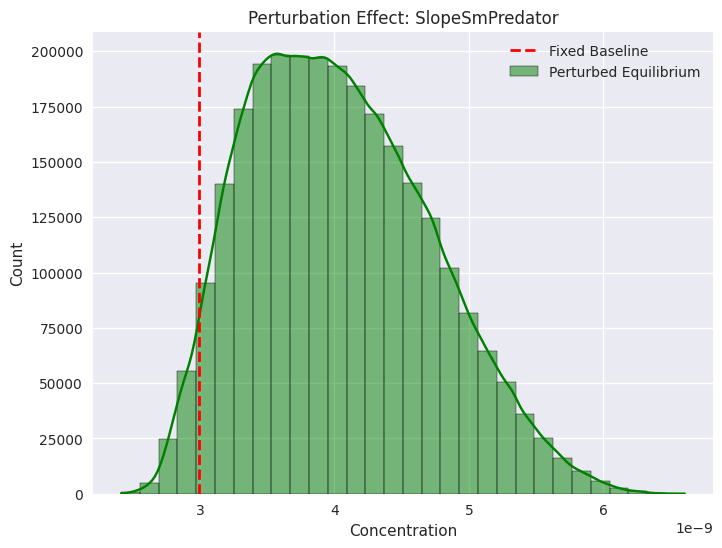

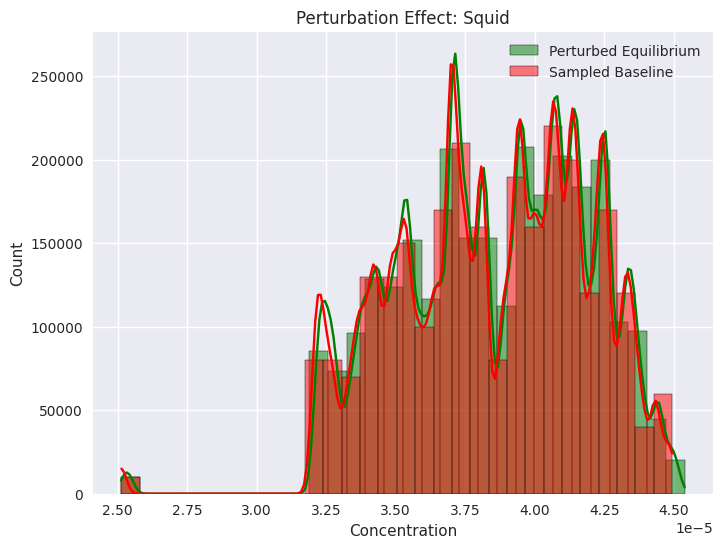

In [9]:
def calculate_perturbed_equilibrium(theta, builder, path_source):
    """
    Worker function to calculate equilibrium for a single parameter set.
    """
    source_sim = builder._create_tracer_source_with_params(theta)
    
    # Apply Perturbation
    source_sim.base_inflow = source_sim.base_inflow * 3.0
    
    # Calculate Equilibrium
    return calculate_equilibrium(path_source, source_sim)

print("Calculating Analytical Equilibria...")

eq_results = Parallel(n_jobs=N_JOBS)(
    delayed(calculate_perturbed_equilibrium)(
        theta, builder, path_source
    )
    for theta in tqdm(mega_ensemble, desc="Equilibrium Calc")
)

eq_array = np.array(eq_results) # Shape: (Samples, Groups)

# %% [markdown]
# ### Visualizing Asymptotic Distributions
#
# We plot the distribution of the final equilibrium concentrations.

# %%
EQUI_PLOT_DIR = os.path.join(PLOT_DIR, "equilibrium")
os.makedirs(EQUI_PLOT_DIR, exist_ok=True)

def plot_equilibrium_hist(eq_data, start_conc_data, group_idx, group_name):
    end_data = eq_data[:, group_idx]
    start_data = start_conc_data[:, group_idx]
    
    plt.figure(figsize=(8, 6))
    
    # Plot New Equilibrium Distribution
    sns.histplot(end_data, kde=True, color='green', bins=30, label="Perturbed Equilibrium", alpha=0.5)
    
    # Check if start data has variance
    if np.std(start_data) < 1e-9:
        # Fixed Group: Plot line
        plt.axvline(np.mean(start_data), color='red', linestyle='--', linewidth=2, label="Fixed Baseline")
    else:
        # Sampled Group: Plot distribution
        sns.histplot(start_data, kde=True, color='red', bins=30, label="Sampled Baseline", alpha=0.5)
    
    plt.title(f"Perturbation Effect: {group_name}")
    plt.xlabel("Concentration")
    plt.ylabel("Count")
    plt.legend()
    
    # Save
    safe_name = group_name.replace(" ", "_")
    plt.savefig(os.path.join(EQUI_PLOT_DIR, f"hist_equi_{safe_name}.png"))
    plt.show()

# Plot distributions
plot_equilibrium_hist(eq_array, mega_ensemble_conc, 0, "Environment")
for i in [1, 5, 20, 35, 46]:
    plot_equilibrium_hist(eq_array, mega_ensemble_conc, i, core.get_functional_group_names()[i].replace("/", " "))